# 1D problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from scipy.stats import rankdata

import tensorflow_probability as tfp
tfd = tfp.distributions


In [2]:
tf.__version__

'2.0.0'

In [3]:
sns.set_style('darkgrid')

In [4]:
def create_data(n, sigma):
    x = np.linspace(0, 1, n)
    y_true = np.sin(x) + 0.5*np.sin(10*x)
    y = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, sigma, x.shape)
    return x, y, y_true

def ranker(obs_array,Ensemble):
    """Compute the rank histogram rankings
    obs_array = np.array[time,];           e.g. obs_array.shape = (136884,)
    Ensemble = np.array([Ensemble,time]);  e.g. Ensemble.shape  = (15, 136884)
     """
    combined=np.vstack((np.array(obs_array)[np.newaxis],Ensemble))
    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    
    return ranks

In [5]:
x_train, y_train, y_true = create_data(1000, 0.15)
x_valid, y_valid, y_true = create_data(1000, 0.15)

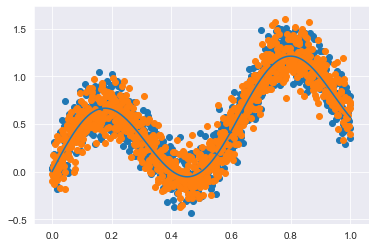

In [6]:
plt.scatter(x_train, y_train)
plt.scatter(x_valid, y_valid)
plt.plot(x_train, y_true);

## Parametric forecast

In [7]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


def crps_loss(y_true, y_pred):
    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]

    # To stop sigma from becoming negative we first have to
    # convert it the the variance and then take the square
    # root again.
    sigma = tf.nn.relu(sigma)

    # The following three variables are just for convenience
    loc = (y_true - mu) / tf.maximum(1e-7, sigma)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))

    # Then we take the mean. The cost is now a scalar
    return crps

In [8]:
x_train, y_train, y_true = create_data(100000, 0.15)
x_valid, y_valid, y_true = create_data(1000, 0.15)

In [9]:
model = tf.keras.models.Sequential([
    Dense(128, input_shape=(1,), activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2)
])

In [10]:
model_prob = tf.keras.models.Sequential([
    Dense(128, input_shape=(1,), activation='elu'),
    Dense(128, activation='elu'),
    Dense(128, activation='elu'),
    Dense(2),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05*t[...,1:])))
])
model_prob.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)


In [74]:
model.compile(tf.keras.optimizers.Adam(1e-5), crps_loss)

In [78]:
model.fit(x_train, y_train, batch_size=20, epochs=10, validation_data=(x_valid, y_valid))

In [11]:
model_prob.fit(x_train, y_train, batch_size=128, epochs=8, validation_data=(x_valid, y_valid))
yhat = model_prob(np.expand_dims(x_valid,axis=1))
s = yhat.stddev().numpy()
m = yhat.mean().numpy()

Train on 100000 samples, validate on 1000 samples
Epoch 1/8
100000/100000 [==============================] - 8s 77us/sample - loss: 0.0016 - val_loss: -0.2418
Epoch 2/8
100000/100000 [==============================] - 5s 53us/sample - loss: -0.3697 - val_loss: -0.2112
Epoch 3/8
100000/100000 [==============================] - 5s 54us/sample - loss: -0.3908 - val_loss: -0.4132
Epoch 4/8
100000/100000 [==============================] - 6s 60us/sample - loss: -0.4062 - val_loss: -0.3919
Epoch 5/8
100000/100000 [==============================] - 6s 64us/sample - loss: -0.4020 - val_loss: -0.3807
Epoch 6/8
100000/100000 [==============================] - 6s 60us/sample - loss: -0.4068 - val_loss: -0.3649
Epoch 7/8
100000/100000 [==============================] - 6s 65us/sample - loss: -0.4117 - val_loss: -0.3387
Epoch 8/8
100000/100000 [==============================] - 5s 54us/sample - loss: -0.4108 - val_loss: -0.3391

If you intended to run this layer in float32, you can safely ignore th

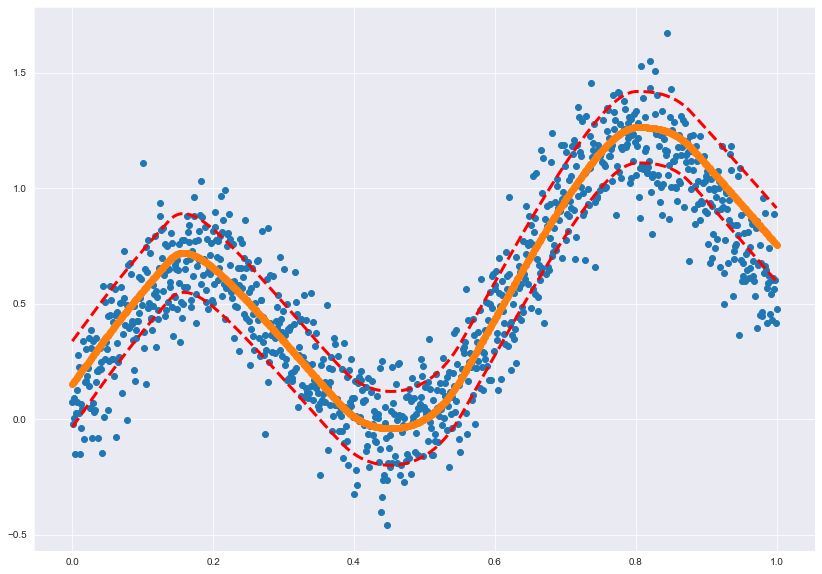

In [12]:
plt.figure(figsize=(14,10))
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid,m)
plt.plot(x_valid,m+s,'r--',linewidth=3)
plt.plot(x_valid,m-s,'r--',linewidth=3)
s = yhat.stddev()


In [13]:
loss_LL = crps_loss(y_valid,np.concatenate([m,s],axis=1)).numpy().mean()
print('CRPS Log Loss:', loss_LL )

CRPS Log Loss: 0.09665888


## Rank Histogram:

In [14]:
#sample from the distribution: 
eN= 60 
allEnse = np.zeros([eN,m.shape[0]])

for ss, mean_ in enumerate(m): 
    allEnse[:,ss]=  np.random.normal(mean_,s[ss],eN)


In [15]:
rr = ranker(y_valid,allEnse)

computing ranks
computing ties


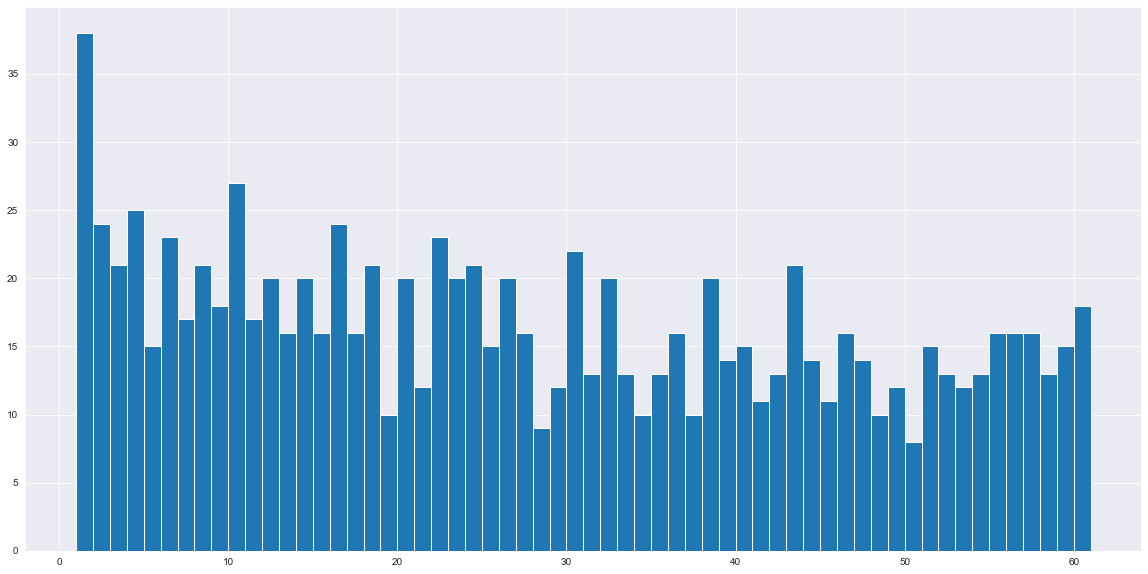

In [16]:
plt.figure(figsize=(20,10))
plt.hist(rr,60)
plt.show()

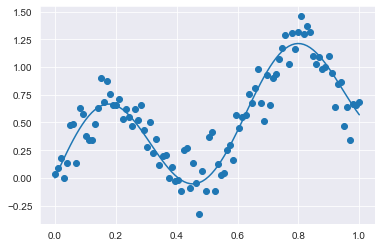

In [5]:
# Gaussian
y = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, 0.15, x.shape)
plt.scatter(x, y)
plt.plot(x, y_true);

In [ ]:
y_train, y_valid = 

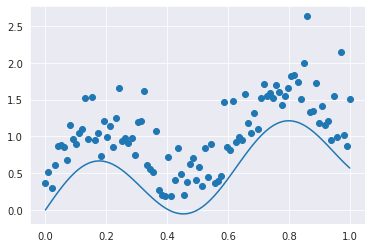

In [ ]:
# Skewed
y = np.sin(x) + 0.5*np.sin(10*x) + np.random.gamma(3, 0.15, x.shape)
plt.scatter(x, y)
plt.plot(x, y_true);

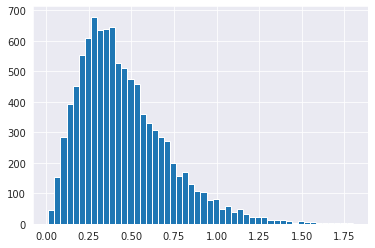

In [ ]:
plt.hist(np.random.gamma(3, 0.15, 10000), bins=50);

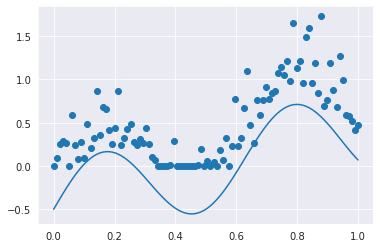

In [ ]:
# Truncated
y = -0.5 + np.sin(x) + 0.5*np.sin(10*x) + np.random.gamma(3, 0.15, x.shape)
y = np.maximum(y, 0)
plt.scatter(x, y)
plt.plot(x, y_true-0.5);

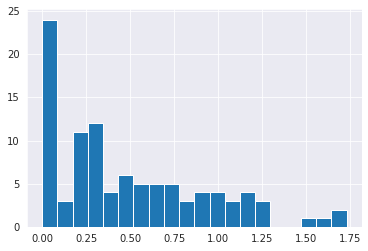

In [ ]:
plt.hist(y, bins=20);

In [ ]:
# Bimodal
y = np.sin(x) + 0.5*np.sin(10*x) + ???
plt.scatter(x, y)
plt.plot(x, y_true);

## 2D example

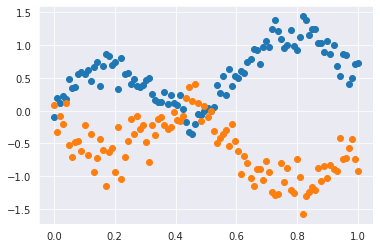

In [ ]:
# Gaussian
y1 = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, 0.15, x.shape)
y2 = -y1 + np.random.normal(0, 0.15, x.shape)
plt.scatter(x, y1)
plt.scatter(x, y2)

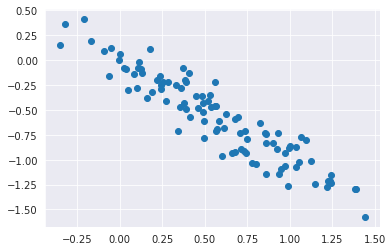

In [ ]:
plt.scatter(y1, y2)